<a href="https://colab.research.google.com/github/sejeong-park/Deeplearning_system/blob/main/ResNet_CIFAR10_ADAM_Momentum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Hyper-parameters
num_epochs = 10
batch_size = 5
learning_rate = 0.001

In [4]:
# Image preprocessing modules
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

In [5]:
# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True, 
                                             transform=transform,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                            train=False, 
                                            transform=transforms.ToTensor())


Extracting ../../data/cifar-10-python.tar.gz to ../../data/


In [6]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [7]:
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)


In [8]:
# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [10]:
# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)
        
    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    

In [12]:
model = ResNet(ResidualBlock, [2, 2, 2]).to(device)

In [13]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


In [17]:
total_step = len(train_loader)
Loss = []
Acc = []
Val_Loss = []
Val_Acc = []

for epoch in range(num_epochs):
  acc = 0
  val_acc = 0
  for i, (images, labels) in enumerate(train_loader):
    model.train()
    images = images.to(device)
    labels = labels.to(device)
    
    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Checking accuracy
    preds = outputs.data.max(dim=1,keepdim=True)[1]
    acc += preds.eq(labels.data.view_as(preds)).cpu().sum()
    
  acc = acc/len(train_loader.dataset) * 100
    
  for i, (images, labels) in enumerate(test_loader):
    model.eval()
    images = images.to(device)
    labels = labels.to(device)
    
    # Forward pass
    outputs = model(images)
    val_loss = criterion(outputs, labels)
    
    # Checking accuracy
    preds = outputs.data.max(dim=1,keepdim=True)[1]
    val_acc += preds.eq(labels.data.view_as(preds)).cpu().sum()
    
  val_acc = val_acc/len(test_loader.dataset) * 100
    
  print("Epoch {} =>  loss : {loss:.2f};   Accuracy : {acc:.2f}%;   Val_loss : {val_loss:.2f};   Val_Accuracy : {val_acc:.2f}%".format(epoch+1, loss=loss.item(), acc=acc, val_loss=val_loss.item(), val_acc=val_acc))
  
  Loss.append(loss)
  Acc.append(acc)

  Val_Loss.append(val_loss)
  Val_Acc.append(val_acc)

Epoch 1 =>  loss : 0.77;   Accuracy : 61.62%;   Val_loss : 0.43;   Val_Accuracy : 70.00%
Epoch 2 =>  loss : 1.45;   Accuracy : 68.78%;   Val_loss : 0.63;   Val_Accuracy : 75.68%
Epoch 3 =>  loss : 0.39;   Accuracy : 73.07%;   Val_loss : 0.17;   Val_Accuracy : 78.05%
Epoch 4 =>  loss : 0.14;   Accuracy : 75.49%;   Val_loss : 0.95;   Val_Accuracy : 78.18%
Epoch 5 =>  loss : 0.40;   Accuracy : 77.29%;   Val_loss : 0.32;   Val_Accuracy : 79.35%
Epoch 6 =>  loss : 1.05;   Accuracy : 78.70%;   Val_loss : 0.47;   Val_Accuracy : 81.04%
Epoch 7 =>  loss : 0.36;   Accuracy : 80.04%;   Val_loss : 0.56;   Val_Accuracy : 81.13%
Epoch 8 =>  loss : 0.88;   Accuracy : 81.05%;   Val_loss : 0.38;   Val_Accuracy : 81.23%
Epoch 9 =>  loss : 0.69;   Accuracy : 81.99%;   Val_loss : 0.48;   Val_Accuracy : 81.16%
Epoch 10 =>  loss : 0.06;   Accuracy : 82.74%;   Val_loss : 0.42;   Val_Accuracy : 82.25%


In [19]:
import matplotlib.pyplot as plt

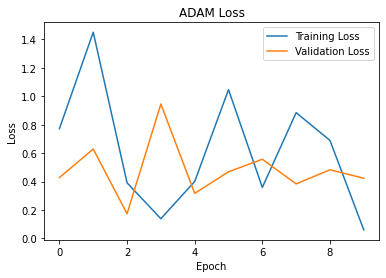

In [23]:
plt.plot(range(num_epochs),Loss)
plt.plot(range(num_epochs),Val_Loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title("ADAM Loss")
plt.legend(["Training Loss", "Validation Loss"])
plt.show()

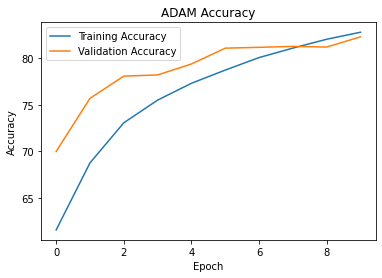

In [24]:
plt.plot(range(num_epochs),Acc)
plt.plot(range(num_epochs),Val_Acc)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title("ADAM Accuracy")
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.show()

In [28]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.5)

In [29]:
# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


In [30]:
total_step = len(train_loader)
Loss = []
Acc = []
Val_Loss = []
Val_Acc = []

for epoch in range(num_epochs):
  acc = 0
  val_acc = 0
  for i, (images, labels) in enumerate(train_loader):
    model.train()
    images = images.to(device)
    labels = labels.to(device)
    
    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Checking accuracy
    preds = outputs.data.max(dim=1,keepdim=True)[1]
    acc += preds.eq(labels.data.view_as(preds)).cpu().sum()
    
  acc = acc/len(train_loader.dataset) * 100
    
  for i, (images, labels) in enumerate(test_loader):
    model.eval()
    images = images.to(device)
    labels = labels.to(device)
    
    # Forward pass
    outputs = model(images)
    val_loss = criterion(outputs, labels)
    
    # Checking accuracy
    preds = outputs.data.max(dim=1,keepdim=True)[1]
    val_acc += preds.eq(labels.data.view_as(preds)).cpu().sum()
    
  val_acc = val_acc/len(test_loader.dataset) * 100
    
  print("Epoch {} =>  loss : {loss:.2f};   Accuracy : {acc:.2f}%;   Val_loss : {val_loss:.2f};   Val_Accuracy : {val_acc:.2f}%".format(epoch+1, loss=loss.item(), acc=acc, val_loss=val_loss.item(), val_acc=val_acc))
  
  Loss.append(loss)
  Acc.append(acc)

  Val_Loss.append(val_loss)
  Val_Acc.append(val_acc)

Epoch 1 =>  loss : 0.37;   Accuracy : 85.46%;   Val_loss : 0.43;   Val_Accuracy : 84.67%
Epoch 2 =>  loss : 0.11;   Accuracy : 85.91%;   Val_loss : 0.41;   Val_Accuracy : 85.12%
Epoch 3 =>  loss : 0.39;   Accuracy : 86.04%;   Val_loss : 0.35;   Val_Accuracy : 84.97%
Epoch 4 =>  loss : 1.28;   Accuracy : 86.13%;   Val_loss : 0.47;   Val_Accuracy : 85.21%
Epoch 5 =>  loss : 0.11;   Accuracy : 86.30%;   Val_loss : 0.39;   Val_Accuracy : 85.22%
Epoch 6 =>  loss : 0.73;   Accuracy : 86.23%;   Val_loss : 0.44;   Val_Accuracy : 85.30%
Epoch 7 =>  loss : 0.89;   Accuracy : 86.49%;   Val_loss : 0.44;   Val_Accuracy : 85.35%
Epoch 8 =>  loss : 0.75;   Accuracy : 86.30%;   Val_loss : 0.57;   Val_Accuracy : 85.39%
Epoch 9 =>  loss : 0.26;   Accuracy : 86.47%;   Val_loss : 0.43;   Val_Accuracy : 85.53%
Epoch 10 =>  loss : 0.12;   Accuracy : 86.55%;   Val_loss : 0.50;   Val_Accuracy : 85.68%


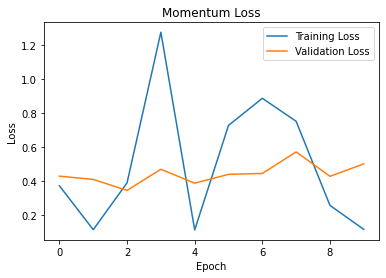

In [31]:
plt.plot(range(num_epochs),Loss)
plt.plot(range(num_epochs),Val_Loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title("Momentum Loss")
plt.legend(["Training Loss", "Validation Loss"])
plt.show()

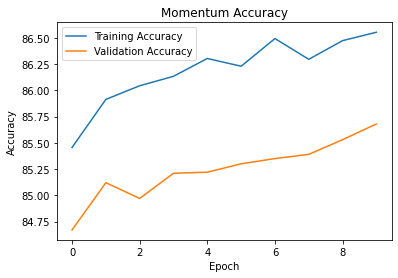

In [32]:
plt.plot(range(num_epochs),Acc)
plt.plot(range(num_epochs),Val_Acc)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title("Momentum Accuracy")
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.show()